## Welcome to the Data Science & Analytics takehome exam. Please submit answers using this Jupyter notebook. Please email zipped files to emi.nakatsugawa@dowjones.com within three days of receiving the exam.

# Scenario

Imagine our team is helping design a campaign to target attendees of the upcoming SXSW festival in 2019. The team would like to better understand website traffic during the most recent SXSW festival (March 2018) to inform what type of content to promote in 2019.

The data in data.csv is a sample of website traffic to wsj.com from first-time visitors who are non-subscribers in the Austin, Texas area (based on IP address).

The objective is to identify which content will turn first-time visitors into loyal readers and subscribers.

<b>Note: Each row in data.csv represents a single page view.</b>
***

# Data

| Column Name	| Description |
|---------------|-------------|
|customerID	|unique customer ID|
|firstVisitDate|	Date and time of customer's first visit|
|secondVisitDate|	Date and time of customer's second visit, if any|
|articleID|	unique ID of the article read on the customer's the first visit|
|section|	section of the article read on the first visit|
|author	|author(s) of the article read on the first visit|
|headline	|headline of the article read on the first visit|
|topicKeywords|	topic keywords in article read on the first visit|
|totalVisits	|the customer's total visits to-date since firstVisitDate|
|wordCount|	word count of the customer's first article|
|videoCount	|number of videos in article|

***

#### Imports

In [292]:
import pandas as pd
import numpy as np
from numpy import sum
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter("ignore")


In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,customerID,firstVisitDate,secondVisitDate,articleID,section,author,headline,topicKeywords,totalVisits,wordCount,videoCount
0,0,2018-03-13 08:41:28 UTC,2018-04-14 00:00:00 UTC,SB11210326209662973945104584092013974171076,WSJ_Business,Theo+Francis,WSJ_Article_Business_Are You Underpaid? In a F...,ceo|ceo to median pay ratio|compensation|dariu...,3,1269.0,0.0
1,1,2018-03-14 08:21:54 UTC,NaN,SB11704195083378974371404584099570957708050,WSJ_Business,Paul Ziobro,WSJ_Article_Business_Drones Are Watching: Rail...,data|drone|drones|employee|employer|employers|...,1,917.0,0.0
2,2,2018-03-13 06:18:59 UTC,NaN,SB12775101498795324251604584089331231148204,WSJ_Opinion,Francesco Ronchi,WSJ_Article_Commentary (U.S.)_Italian Voters D...,5-star movement| election|italy| populism| the...,1,895.0,0.0
3,3,2018-03-15 14:18:43 UTC,NaN,SB11027093093037343542404584101860399949656,WSJ_Business,Tim+Higgins,WSJ_Article_Autos_Tesla’s Make-Or-Break Moment...,elon musk |tesla|tesla cash burn|tesla debt|te...,1,951.0,0.0
4,4,2018-03-16 12:56:19 UTC,NaN,SB11027093093037343542404584103340219066918,WSJ_Markets,Laura+Saunders,WSJ_Article_Tax Report_Do You Own Bitcoin? The...,asset|bitcoin|capital gains |coinbase|cryptocu...,1,903.0,1.0


In [4]:
data.describe()

,customerID,totalVisits,wordCount,videoCount
count,10000.000000,10000.000000,9598.000000,9598.000000
mean,4708.803500,1.424000,1060.386435,0.337258
std,2717.082857,2.734369,594.750859,0.648440
min,0.000000,1.000000,0.000000,0.000000
25%,2357.750000,1.000000,687.250000,0.000000
50%,4709.500000,1.000000,972.500000,0.000000
75%,7070.250000,1.000000,1248.000000,1.000000
max,9407.000000,117.000000,8723.000000,4.000000


In [5]:
# customerID is not unique, there are few duplications 
np.unique(data.customerID)

array([   0,    1,    2, ..., 9405, 9406, 9407], dtype=int64)

In [6]:
# example 
data[data["customerID"] == 12]

,customerID,firstVisitDate,secondVisitDate,articleID,section,author,headline,topicKeywords,totalVisits,wordCount,videoCount
12,12,2018-03-13 09:48:07 UTC,2018-06-01 00:00:00 UTC,SB10053721253826474326804584099101464018882,WSJ_Politics,Michael C. Bender,WSJ_Article_Politics and Policy_Trump’s Person...,aide fired|mcentee fired|personal assistant|se...,4,657.0,0.0
13,12,2018-03-13 09:48:05 UTC,2018-06-01 00:00:00 UTC,SB10053721253826474326804584099101464018882,WSJ_Politics,Michael C. Bender,WSJ_Article_Politics and Policy_Trump’s Person...,aide fired|mcentee fired|personal assistant|se...,4,657.0,0.0


In [7]:
# we are just dropping the observations which have same customerID and articleID

# drop duplicates, reset the index and then drop the 'index' column. 
wsjdata = data.drop_duplicates(subset=["customerID","articleID"]).reset_index().drop(['index'], axis=1)

In [8]:
# also drop "NaN"s
wsjdata = wsjdata.dropna(subset=['totalVisits','wordCount','videoCount'])

# Questions

### 1. What percent of customers returned after the first visit?

In [10]:
first = wsjdata[wsjdata['totalVisits']==1]
other = wsjdata[wsjdata['totalVisits']!=1]

print(round((len(other)/len(wsjdata)*100),2))

12.17


### Ans - Approximately 12% people returned, i.e they had visits more than 1.  

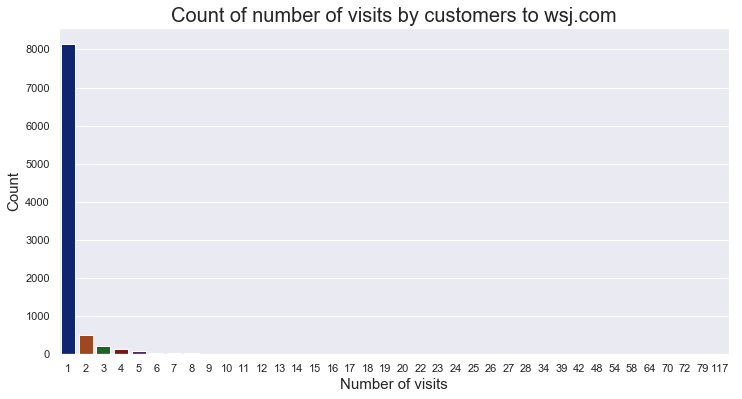

In [11]:
# a plot to show the number of observations for each 'totalVisits' column

plt.figure(figsize=(12,6))
sns.countplot(wsjdata.totalVisits, palette='dark')
plt.title("Count of number of visits by customers to wsj.com", fontsize=20)
plt.ylabel("Count", fontsize=15)
plt.xlabel("Number of visits", fontsize=15);

### 2. What are the top three best-performing stories in each section, by pageviews?

We want to know for each section, what are the most read headlines and at the same time which article had maximum returning readers. I believe this is the way, we can evaluate performance. 

In [171]:
# we will use "other" dataset
# other.head()

In [185]:
other[other["section"]=="WSJ_Markets"].headline.value_counts().index[0:3]

Index(['WSJ_Article_Tax Report_Do You Own Bitcoin? The IRS Is Coming for You',
       'WSJ_Article_Markets Main_Intel Considers Possible Bid for Broadcom',
       'WSJ_Article_Markets Main_Lloyd Blankfein Prepares to Exit Goldman Sachs as Soon as Year’s End'],
      dtype='object')

In [206]:
def evaluater(section_list):
    '''
    a function to evaluate the top 3 headlines in each section, where readers returned
    param: list - list of sections 
    '''
    for i in section_list:
        
        # get the section dataset
        data = other[other["section"]==i]
        
        # get the highest read headlines
        top_3_headlines = data.headline.value_counts().index[0:3]
        
        print("\n")
        print("For the {} section, the top 3 best performing stories are:".format(i))
        for j in top_3_headlines:
            print(j)


In [207]:
sec_list = wsjdata.section.unique()

In [209]:
evaluater(section_list=sec_list)



For the WSJ_Business section, the top 3 best performing stories are:
WSJ_Article_Business_How Your Returns Are Used Against You at Best Buy, Other Retailers
WSJ_Article_Business_Toys ‘R’ Us Tells Workers It Will Likely Close All U.S. Stores
WSJ_Article_Business_Are You Underpaid? In a First, U.S. Firms Reveal How Much They Pay Workers


For the WSJ_Opinion section, the top 3 best performing stories are:
WSJ_Article_Commentary (U.S.)_The Exhaustion of American Liberalism
WSJ_Article_Review & Outlook (U.S.)_Andrew McCabe and Consequences
WSJ_Article_Review & Outlook (U.S.)_The Trump Tariff Layoffs Begin


For the WSJ_Markets section, the top 3 best performing stories are:
WSJ_Article_Tax Report_Do You Own Bitcoin? The IRS Is Coming for You
WSJ_Article_Markets Main_Intel Considers Possible Bid for Broadcom
WSJ_Article_Markets Main_Lloyd Blankfein Prepares to Exit Goldman Sachs as Soon as Year’s End


For the WSJ_Politics section, the top 3 best performing stories are:
WSJ_Article_Politi

### 3. Based on this data, would you choose to promote a Tech story or a Markets story on social media? Why?

Let us calculate visit the data and its statistics first:


In [220]:
def conversion_per(section_list):
    '''
    a function to calculate the percent of visitors who returned for a specific sections
    param: list - a list of sections 
    return list -  a list of percentage values
    '''
    # an empty list to store values in
    per_list=[]
    
    # looping through the sections list
    for i in section_list:
        
        # section data
        d1 = wsjdata[(wsjdata["section"]==i)]

        # section data with multiple visits
        d3 = wsjdata[(wsjdata["section"]==i) & (wsjdata["totalVisits"]!=1)]
        
        # percentage
        d_per = round(len(d3)/len(d1)*100, 2)
        
        # append
        per_list.append(d_per)
        
        print("Number of readers in {} section: {}".format(i, len(d1)))
    return per_list

In [221]:
list1 = ["WSJ_Markets","WSJ_Tech"]

In [222]:
per_list1 = conversion_per(section_list=list1)

Number of readers in WSJ_Markets section: 852
Number of readers in WSJ_Tech section: 624


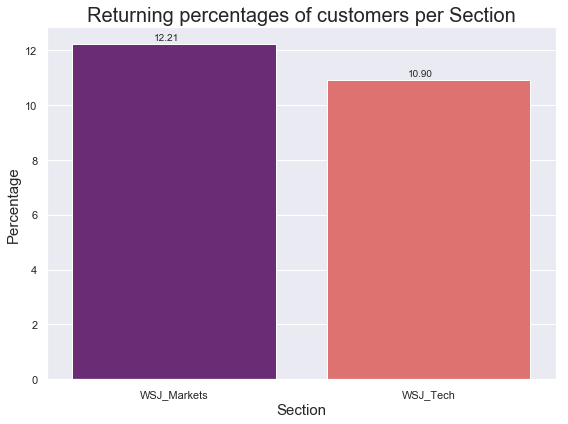

In [223]:
# plot of 
plt.figure(figsize=(8,6))
x = sns.barplot(list1, per_list1, palette="magma")

for i in x.patches:
    x.annotate(format(i.get_height(), '.2f'), (i.get_x() + i.get_width() / 2.5, i.get_height()), 
                    xytext = (0, 4), textcoords = 'offset points');

plt.title("Returning percentages of customers per Section", size=20)
plt.xlabel("Section", size= 15)
plt.ylabel("Percentage", size = 15)

plt.tight_layout()

Answer - 
I believe we first need to know the objective of the content promotion. Our aim is to drive our visitors to become loyal readers and subscribers. 

According to the data, the number of readers for both the sections are different. Market has more readers and the reason is because the time here is important. It's March, which is the end of quarter Q2 of the fiscal year. The time when people are thinking about filing taxes, quarter earnings etc. Readers (maximum readers) don't want to know which smartphone is coming or what Virtual Reality is innovated. People would want to know the status of market at this time. Had it been month of August, when new technologies are launched, I would have chosen Tech. 

To add to that, our customer reach can be higher than 852 if market section is promoted more at this time with beautiful articles, increasing our chances to higher conversion rates.

So, my answer is **"Market"** section


### 4. Create a visualization exploring the relationship between any of the content characteristics (such as section, author, keywords etc...) and returning visitors. This is an open-ended task. Briefly describe the visualization and the insight.

In [59]:
# convert firstVisitDate to datetime format  
wsjdata.firstVisitDate = pd.to_datetime(wsjdata.firstVisitDate)

# also, the second visit
wsjdata.secondVisitDate = pd.to_datetime(wsjdata.secondVisitDate)

##### Relationship 1 - Word count 

Let's start with word count. How is word count impacting the readers? 

Word count analysis is a bit confusing, so we are going to inculcate how many minutes does it take to read an article. 

Average adult can read at 200-250 words-per-minute. We can create a new metric named "x min read" per article by dividing the word count by reading speed. Let us select 225 wpm. 

In [289]:
# formulation
wsjdata['x_min_read'] = wsjdata.wordCount.apply(lambda x: int(x/225) )

In [290]:
# example 
wsjdata.x_min_read[0:10]

0    5
1    4
2    3
3    4
4    4
5    4
6    3
7    2
8    5
9    5
Name: x_min_read, dtype: int64

In [297]:
first['x_min_read'] = first.wordCount.apply(lambda x: (x/225) )
other['x_min_read'] = other.wordCount.apply(lambda x: (x/225) )

(0, 10)

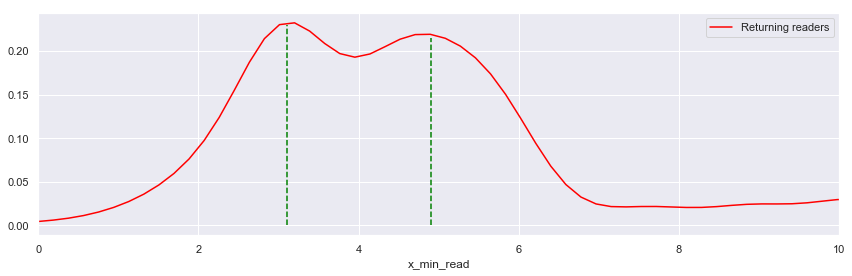

In [318]:
###### are people really lazy to read long articles? Let's find out
# we have two datasets already defined, 'first' and 'other'
plt.figure(figsize=(12,4))
sns.distplot(other.x_min_read,  color= "red", hist=False, label = "Returning readers");

plt.vlines(3.1, 0, 0.23,colors='green', linestyles="dashed" )
plt.vlines(4.9, 0, 0.215,colors='green', linestyles="dashed" )

plt.tight_layout()

# set limits for better understanding
plt.xlim(0,10)

If we look closely, there is a hike in reader's frequency at approx 3 min read and 5 min read of the articles. This says there is a relationship at these points. 
We can recommend the authors to limit the articles to make them a 3 min or 5 min reads.

##### Relationship 2 - Opinion section

In [46]:
# define a new section list for all the sections
list2 = wsjdata.section.unique()

# feed it to the earlier function defined
per_list2 = conversion_per(list2)


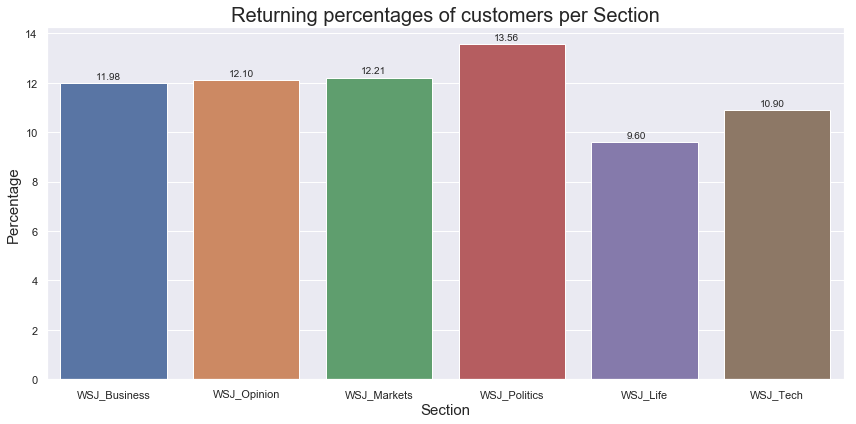

In [47]:
# plot for all sections
plt.figure(figsize=(12,6))
x = sns.barplot(list2, per_list2)

for i in x.patches:
    x.annotate(format(i.get_height(), '.2f'), (i.get_x() + i.get_width() / 3., i.get_height()), 
                    xytext = (0, 4), textcoords = 'offset points');

plt.title("Returning percentages of customers per Section", size=20)
plt.xlabel("Section", size= 15)
plt.ylabel("Percentage", size = 15)
plt.tight_layout()

We see that even if opnion section has quite low number of observations, the resturning user pecentage is quite high (equal to markets). Which means that readers tend to like the opinions and editorial board articles in **Opinion section**. These might happen because they are either for or against the opinion and they go back and forth to even read the comments or may be leave behind their thoughts. In the data, we also see some readers coming more than 100 times to a specific article. In my thought, Opinion section is one of the best places to start the promotion. 

##### Relationship 3 - Trump topics

In [48]:
# we have seen readers are so much into politics and opinions. I wanted to explore what consititutes the reads.
wsjdata['Trump'] = wsjdata.headline.apply(lambda x: 1 if ("Trump" in x) else 0)

In [49]:
## find the conversion percentage when trump was mentioned 
trump_returned = wsjdata[(wsjdata["Trump"] == 1) & (wsjdata['totalVisits'] != 1)]


In [50]:
round(len(trump_returned)/len(wsjdata)*100, 2)

4.18

So out of 12.17 % returning visitors, 4.2 % are the ones who read Trump related articles and came back. Americans do care about the news related to their president and we cant blame them. Most of the content was about 

1. Trump's communication director resigned - Impact on presidency 
2. Rex Tillerson, Secretary of state was fired on March 14th. 
3. Trump's 2020 presidential campaign 

Trump articles are good place to start with promotion, looking at what major content is involved. 

##### Relationship 4 - Michael C. Bender articles

In [51]:
# defining a function 
def plus_remover(word):
    '''
    a function to remove "+" from names
    param: str - name of the author we want to edit
    return str - edited author name, with no "+"
    '''
    
    if '+' in word:
        word = word.replace("+"," ")
    return word

In [52]:
# apply it to the author
other.author = other.author.dropna().apply(lambda x: plus_remover(x))

C:\Users\raghu\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [53]:
# make a new categorical column
other["Michael_article"] = other.author.dropna().apply(lambda x: 1 if ("Michael C. Bender" in x) else 0)

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
other.Michael_article.value_counts()

# constitutes approx 20%
226/1113

# we see that almost 20% of the articles read by returning users were written by Michael C. Bender. 
# We need to study the impact 

0.20305480682839172

In [56]:
# applying to the main dataset
wsjdata.author = wsjdata.author.dropna().apply(lambda x: plus_remover(x))

wsjdata["Michael_article"] = wsjdata.author.dropna().apply(lambda x: 1 if ("Michael C. Bender" in x) else 0)

In [57]:
michael = wsjdata[(wsjdata["Michael_article"] == 1) & (wsjdata["totalVisits"] != 1)]

len(michael)/len(wsjdata)

0.02435344827586207

Also, over almost 2.5 % of the returning readers were interested in his articles. That's a plus point for us

In [60]:
# Just engineering a new variable for further analysis
wsjdata['hour'] = wsjdata.firstVisitDate.apply(lambda x: x.hour)

### 5. Create a simple model predicting the likelihood of a first-time visitor returning.

Again to revisit, we will create a categorical variable to determine whether the visitor will return or not, denoted by 'catVisits'


In [61]:
# this means that if totalVisits were 1, we give it 1, for returning readers we give 0. 
wsjdata['catVisits'] = wsjdata.totalVisits.apply(lambda x: 1 if x == 1 else 0)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from copy import copy

In [63]:
# First, let's make a copy of the data
train = wsjdata.copy()

In [64]:
# convert the section into categorial data
train['section'] = pd.Categorical(train['section'])
train['section'] = train['section'].cat.codes

In [711]:
# train = pd.concat([train, pd.get_dummies(train.section, columns=train.section.values)], axis = 1)

In [65]:
# remove the unecessary columns for the model. 

# we are using catVisits, so no need of totalVisits
# no use of firstVisitDate and secondVisitDate 
# customerID and articleID are pointless, they are just a ID which we should ot use so that model does not "memorize"
# videoCount seems to worsen the model a bit, so we removed it.
# topicKeywords can be used by deriving a feature, but for simplicity, we are not 

X = train.drop(["customerID", "articleID", "firstVisitDate", "secondVisitDate", "videoCount", "totalVisits", "topicKeywords","author","headline"],axis=1)


In [66]:
X = X.dropna()

y = X["catVisits"]
del X['catVisits']

In [67]:
len(X) == len(y)

True

In [68]:
# split it into train and test 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size =0.3, random_state=4)

##### Logistic Regression

In [224]:
# Logistic regression model and fitting 
logmodel = LogisticRegression(random_state=4)

print(logmodel)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=4, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [226]:
# fit into training data 
logmodel.fit(Xtrain, Ytrain)

C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=4, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

###### Prediction

In [228]:
# prediction of test set
test = logmodel.predict(Xtest)

# build the confusion matrix
cm = metrics.confusion_matrix(Ytest, test)

# score of the model
score = logmodel.score(Xtest,Ytest)

print(score)

0.887721839913075


###### Confusion matrix

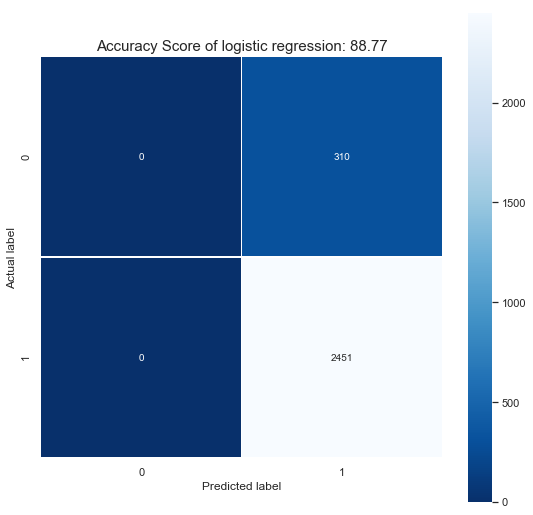

In [230]:
# plot of the confusion matrix 
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score of logistic regression: {0}'.format(round(score*100, 2))
plt.title(all_sample_title, size = 15);

The model surely gives 88% accuracy score by that doesn't make sense because it can't predict even 1 returning reader correctly. That's a very poor model. So I wanted to give a try with Random Forest Classifier. 

##### Random Forest Classifier

In [231]:
# model
rf = RandomForestClassifier(n_estimators=500, random_state=4, oob_score=True)

print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=4, verbose=0, warm_start=False)


In [232]:
rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=4, verbose=0, warm_start=False)

###### Prediction

In [233]:
# prediction
test2 = rf.predict(Xtest)

# confusion matrix 
cm2 = metrics.confusion_matrix(Ytest, test2)

# scoring 
score2 = rf.score(Xtest,Ytest)

print(score2)

0.8659905831220572


###### Confusion matrix

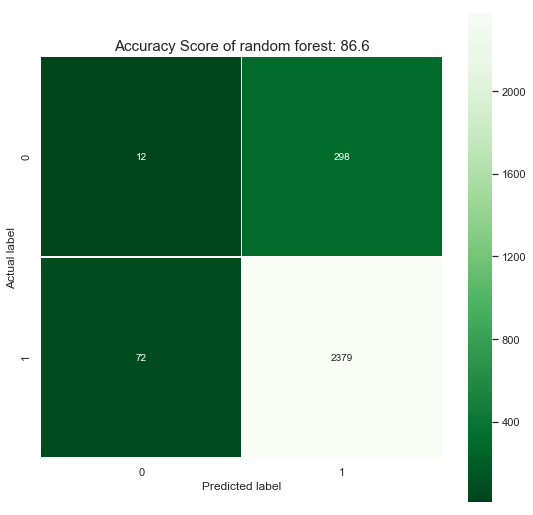

In [234]:
# plot for confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score of random forest: {0}'.format(round(score2*100, 2))
plt.title(all_sample_title, size = 15);

You see, even though the accuracy score is less, our model predicts some occurences of returning readers. That is why random forest comes to the rescue. But still, the model isn't anywhere near best. 

### 6. What additional data would you add to improve the model? (Answer in 3-5 sentences)

We saw two basic models being run with small changes in the predictors. We featured engineered for 2-3 predictors. 
There are many ways by which we can improve the model - 

1. Increase the number of observations for "returning readers". Basically the data is imbalanced and bit of biased towards non-returning viewers. I know this is the real case scenario and there are such less observations. 

2. "Time spent on the website or page" - Even if he or she spends more time than usual, that data can be used as a good predictor to guide our model for better predictions. 

3. Number of clicks per section

4. Segregation of people who came through a marketing advertisement or just by search on google. If the visitor is on wsj.com by clicking on an advertisement, he/she might have liked it as well as the content headline. 

5. "Search pattern data" can add a lot to the model, basically if people search for what they want and luckily they get it, it is a plus point for us to drive them to be our local customer and subscriber. 


### 7. What other interesting stories can you tell with this data?

##### Investigation of returning readers, visiting more than 10 times

In [111]:
# number of visits greater than 10
morethan10 = wsjdata[wsjdata["totalVisits"]>10]

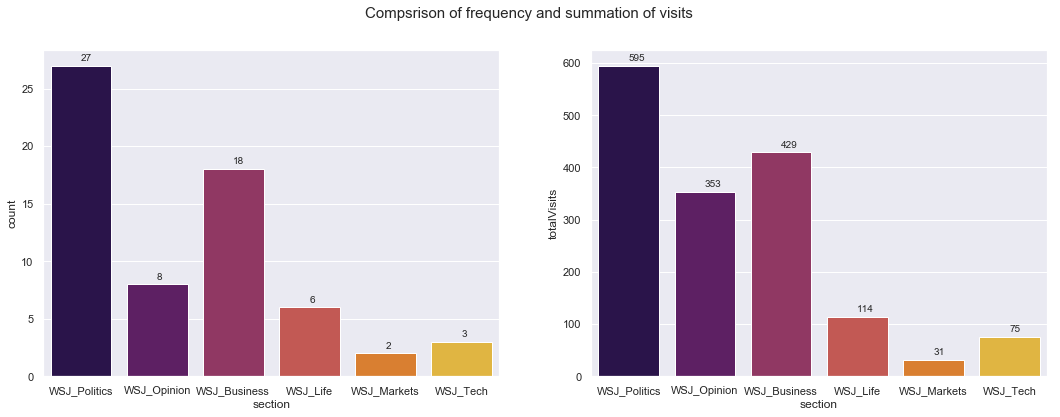

In [113]:
# this can be done by a simple countplot by seaborn

# Creates two subplots of both 
f, axes = plt.subplots(1, 2,figsize=(18, 6))

# title 
f.suptitle("Compsrison of frequency and summation of visits", size=15)

x = sns.countplot(morethan10.section,ax=axes[0] ,palette='inferno')
y = sns.barplot(morethan10.section, morethan10.totalVisits, palette="inferno",estimator=sum, ax=axes[1],ci=None ) 
# plt.title("Section division of customers by number of visits at wsj.com", fontsize=20)
# plt.ylabel("Number of visits", fontsize=15)
# plt.xlabel("Section", fontsize=15)

for i in x.patches:
    x.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), 
                    xytext = (0, 5), textcoords = 'offset points');
    
for i in y.patches:
    y.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), 
                    xytext = (0, 5), textcoords = 'offset points');

As mntioned earlier, "Opinion" blows my mind. Even though there are just observations, they account to 363 visits. That sounds intriguing to me on what topic they are discussin about. We can check it out here: 



In [115]:
morethan10[morethan10["section"]=="WSJ_Opinion"] # Russion | Putin | Climate change | Elizabeth Warren 

,customerID,firstVisitDate,secondVisitDate,articleID,section,author,headline,topicKeywords,totalVisits,wordCount,videoCount,Trump,Michael_article,hour,catVisits
904,887,2018-03-12 08:26:00+00:00,2018-03-13 00:00:00+00:00,SB11513260795640254558004584085581177203524,WSJ_Opinion,Oren Cass,WSJ_Article_Commentary (U.S.)_Doomsday Climate...,adaptation|climate change| deaths| global warm...,72,949.0,0.0,0,0.0,8,0
1581,1539,2018-03-14 16:26:59+00:00,2018-03-23 00:00:00+00:00,SB11513260795640254558004584085470343058620,WSJ_Opinion,Arthur C. Brooks,WSJ_Article_Commentary (U.S.)_Reflections on a...,aei|american enterprise institute| debate| ide...,20,674.0,0.0,0,0.0,16,0
1631,1589,2018-03-11 10:29:35+00:00,2018-03-16 00:00:00+00:00,SB11513260795640254558004584085764131912266,WSJ_Opinion,Jason L. Riley,WSJ_Article_Upward Mobility_50 Years of Blamin...,great society|race relations|political|general...,13,819.0,0.0,0,0.0,10,0
3119,3050,2018-03-13 07:29:31+00:00,2018-03-23 00:00:00+00:00,SB12775101498795324251604584091714098795566,WSJ_Opinion,James Freeman,WSJ_Article_Best of the Web Today_Working Again,political|general news|disasters|accidents|flo...,15,549.0,0.0,0,0.0,7,0
3205,3130,2018-03-16 17:49:02+00:00,2018-03-17 00:00:00+00:00,SB10385287216379884548704584103473343707450,WSJ_Opinion,The Editorial Board,WSJ_Article_Review & Outlook (U.S.)_Vladimir T...,attack| britain|nerve agent| novichok| russia|...,117,544.0,0.0,0,0.0,17,0
3231,3154,2018-03-15 22:17:19+00:00,2018-03-20 00:00:00+00:00,SB10385287216379884548704584103573829894250,WSJ_Opinion,Peggy Noonan,WSJ_Article_Declarations_Deliverance From Hill...,2016 election|2018|conor lamb|deplorables|dona...,18,1295.0,0.0,0,0.0,22,0
7248,7059,2018-03-18 18:04:26+00:00,2018-03-20 00:00:00+00:00,SB10342241267609484717704584105923688516410,WSJ_Opinion,The Editorial Board,WSJ_Article_Review & Outlook (U.S.)_Elizabeth ...,Consumer Financial Protection Bureau|Elizabeth...,79,382.0,0.0,0,0.0,18,0
7573,7378,2018-03-18 11:12:25+00:00,2018-03-21 00:00:00+00:00,SB11115384206897403412704584097762452736046,WSJ_Opinion,William A. Galston,WSJ_Article_Politics & Ideas_Why Cities Boom W...,cities|economic growth|populism|rural areas|tr...,19,785.0,0.0,0,0.0,11,0


##### Returning user investigation - Return time  

In [141]:
# convert firstVisitDate to datetime format  
other.firstVisitDate = pd.to_datetime(other.firstVisitDate)

# also, the second visit
other.secondVisitDate = pd.to_datetime(other.secondVisitDate)

C:\Users\raghu\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [142]:
# apply it to the dataset

# subtract the secondVisitDate and firstVisitDate to know when is the reader returning back
other["returnDays"] = other.apply(lambda x: (x.secondVisitDate - x.firstVisitDate).days, axis=1)

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [143]:
# exmaple. 
other.returnDays[0:10]

0     31
12    79
24    56
30    74
34    12
37    28
46    31
54    19
56     0
68     3
Name: returnDays, dtype: int64

The hypothesis here is that if we are specifically focussing on these specific days of March during the SXSW festival, we don't really care about the people who returned back after 60 days (2 months). 

We want to focus on the readers who came back in the span of 10 days of the festival, because that period is what we want to know in 2019 as well. 

In [145]:
# a dataframe to focus on readers returning within 10 days of reading the article and to know their characteristics
tenreturn = other[other["returnDays"] < 10]

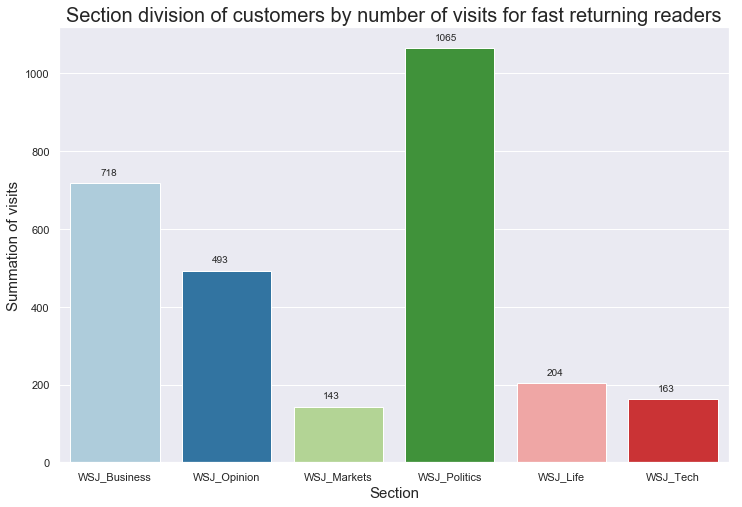

In [153]:
# this can be done by a simple countplot by seaborn

plt.figure(figsize=(12,8))
x = sns.barplot(tenreturn.section,tenreturn.totalVisits, palette='Paired', estimator=sum, ci=None)
plt.title("Section division of customers by number of visits for fast returning readers", fontsize=20)
plt.ylabel("Summation of visits", fontsize=15)
plt.xlabel("Section", fontsize=15)

for i in x.patches:
    x.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 3., i.get_height()), 
                    xytext = (0, 8), textcoords = 'offset points');

Boom! We got different interests of fast returning users. "Opinion", "Life" and "Tech" have **more** visits than "Market" section, which was not the case before.

Why we are focusing on these readers is because we can understand their behavior and get immediate results that our promotion campaign is working efficiently. 

##### WSJ_LIFE investigation

We see that WSJ_Life is always lacking behind in all respects. Obviously, readers aren't interested in such articles. But let's investigate some of it

In [158]:
life = wsjdata[wsjdata["section"]=="WSJ_Life"]

In [166]:
life_return = life[life["totalVisits"] != 1]

In [169]:
life_return.headline.value_counts()[0:20]

WSJ_Article_The Saturday Essay_The Truth About the SAT and ACT                                        11
WSJ_Article_The Saturday Essay_The Enlightenment             Is Working                                8
WSJ_Article_Life & Style_The Hottest Social Scene in Town Isn’t the Singles’ Bar. It’s the Sup         7
WSJ_Article_The Saturday Essay_How to Be Healthier, Happier and More Productive: It’s All in the T     7
WSJ_Article_The Saturday Essay_My 10-Year Odyssey Through America’s Housing Crisis                     6
WSJ_Article_Life & Style_Why 4 a.m. Is the Most Productive Hour                                        6
WSJ_Article_The Saturday Essay_The Secrets of Resilience                                               5
WSJ_Article_Life & Style_20-Somethings Embrace Clean Living                                            5
WSJ_Article_Essay_How Kubrick’s ‘2001: A Space Odyssey’ Saw Into the Future                            4
WSJ_Article_NFL_The Quarterback Whose Decision Will Upe

If we look at top 20 articles in "WSJ_Life" section of the returning users, we see Saturday Essays are most read. If we choose to promote any life section article, they should be the saturday essays to improve them 

###### Word clioud

In [245]:
import wordcloud

In [268]:
# we will go through the dataset of non-returning users
text1 = first.topicKeywords.str.cat(sep=" ").replace("|"," ").replace("donald trump", "Donald Trump")

In [269]:
text2 = other.topicKeywords.str.cat(sep=" ").replace("|"," ").replace("donald trump", "Donald Trump")

In [331]:
wc1 = wordcloud.WordCloud(background_color="white").generate(text1)

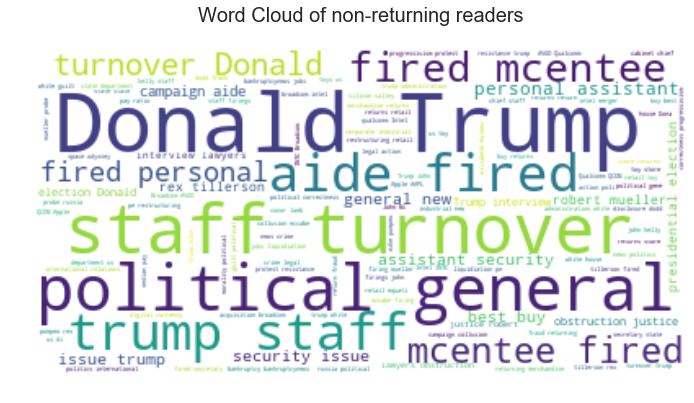

In [332]:
plt.figure(figsize=(12,6))
plt.imshow(wc1, interpolation='bilinear')
plt.title("Word Cloud of non-returning readers"+"\n", size=20)
plt.axis("off");

In [333]:
wc2 = wordcloud.WordCloud(background_color="white").generate(text2)

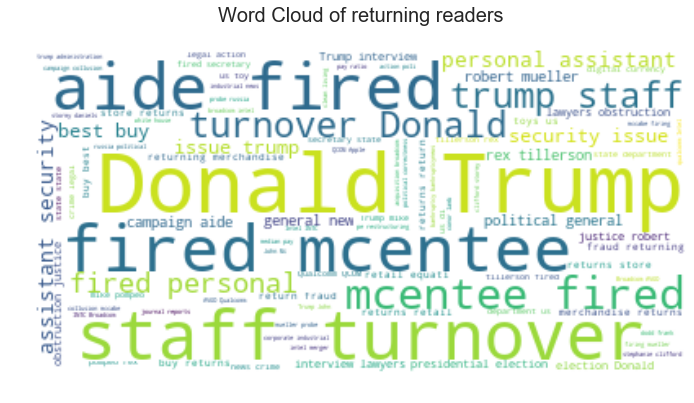

In [334]:
plt.figure(figsize=(12,6))
plt.imshow(wc2, interpolation="bilinear")
plt.title("Word Cloud of returning readers"+"\n", size=20)
plt.axis("off");

This is in an interesting piece of content. We see that both the type of articles have same word cloud which suggests that headlines and the content of articles are not a driving the visitors to return again, but other factors stated above and some unknown ones. 

###### Word count

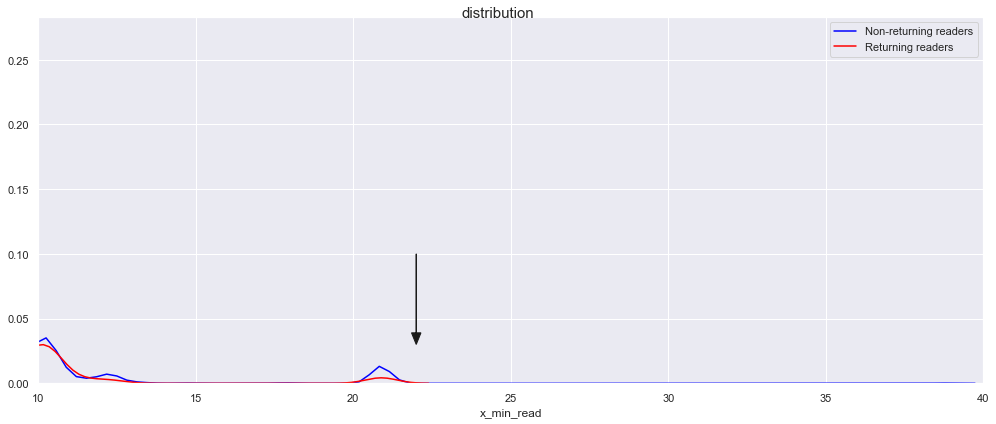

In [372]:
###### are people really lazy to read long articles? Let's find out
# we have two datasets already defined, 'first' and 'other'

# Creates two subplots of both 
f, axes = plt.subplots(1, 1,figsize=(14, 6))

# title 
f.suptitle("distribution", size=15)

# set limits for better understanding

sns.distplot(first.x_min_read, color="blue", hist=False, label = "Non-returning readers")
sns.distplot(other.x_min_read,  color= "red", hist=False, label = "Returning readers");

axes.arrow(22, 0.1, 0, -0.07,  head_width=0.3, head_length=0.009,length_includes_head=True,
          fc='k', ec='k')
plt.tight_layout()
plt.xlim(10,40)
plt.show()

I changed the limit of the graph for the further analysis. 

We see that **returning readers** do not even read articles of length more than 22 minutes. And **non-returning** having once read that weren't impressed by the length. It might be possible that it was tiresome. 

So we should recommend **<20 min reads** to our visitors, irrespective of the section. 

#### Thoughts 

There are obviously many factors to look into while analyzing the website traffic. People's interests are changing every year and its almost impossible to guess that. 

But with the given data and the recommendations given by me, I believe we can track these visitors and make them to become our loyal readers and subscribers. 

One of the huge factor driving people into us, is by offering them better subscription plans during this period given that the SXSW festival is an annual thing. 